Takes the results from both methods (IRG and U-NEt), introduce on a pandas dataset, saves it on csv and creates a boxplot with the comparison

In [9]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from nilearn import image
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'C:/3DUnetCNN-master/brats/')
from preprocess_ipo_utils import read_data, HU_conversion
from scipy.ndimage import zoom
sys.path.insert(0,'C:/3DUnetCNN-master/unet3d/')
from metrics import compare_volumes_lighter, Dice, Jac, TruePR, VoluM, dice_coefficient
from 3DRegionGrowing.segmentation_functions import resample
from preprocess import arrange_slices
import scipy.io as spio
import pydicom
import pandas as pd
import seaborn


def get_lung_mask(data):
    return data == 1


results = list()
subject_ids = list()

prediction_path = "C:/results/23teste/3DUnetCNN-master/brats/prediction/"
prediction_folder = os.listdir(prediction_path)
in_folder= "G:/CTimages/original/"
mask_folder = "G:/Masks/pares/"
separate_mask_folder = "G:/Masks/separated/"
separation_path = "G:/Results/Separator/"
rg_results_path = "G:/Results/segmentation_results/Iterative/third/"
#header= ("Patient - region","Dice_rg","dice_unet","jac_rg","jac_unet","truePr_rg","truePr_unet","vs_rg","vs_unet")
#header= ("Dice","Jac","TPr","VS","Method")
header= ("RG","U-Net","Metric")


for num, result in enumerate(prediction_folder):
    print('\n\nPatient: ',result)
    print(num)
    

    #predict_file
    prediction_file = prediction_path+result+'/'+"{0}_prediction.nii.gz" #gives the exact path to "predicition.nii.gz" 
    prediction_image = nib.load(prediction_file)
    prediction = prediction_image.get_data()

    #original-file/original_mask (we only want the original shae)
    truth = np.load(mask_folder+'mask_'+result+'.npy')
    separador = spio.loadmat(separation_path+'/'+result+'_separator', squeeze_me=True)["separator"]
   
    slices= arrange_slices(in_folder,result)
    resize_factor = np.array(truth.shape) / np.array(prediction.shape)
    new_real_shape = prediction.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / prediction.shape

    result_orig_size = zoom(prediction, real_resize_factor, order=1)
    #dice_coefficient = dice_coefficient(get_lung_mask(truth), get_lung_mask(resampled_image))
    TP, TN, FP, FN = compare_volumes_lighter(truth,result_orig_size)
    dice = round(Dice(TP,FP,FN),3)
    jac = round(Jac(TP,FP,FN),3)
    truePr = round(TruePR(TP,FN),3)
    vs = round(VoluM(TP,FP, FN),3)
    print('dice: ',dice,", jac: ",jac, ",true positive rate: ", truePr, ", volume similarity: ", vs)
    
    regions = ("left", "right")
    for region in regions:
        
        
        probable_name = "3DVolumeSegmented_"+result+"_"+region
        probable_rg_file = [i for i in os.listdir(rg_results_path) if os.path.isfile(os.path.join(rg_results_path,i)) and \
         probable_name in i]
        if len(probable_rg_file) != 0:
#         #Reading the data--------------------------------------------------------------------------------------------------------
#         
#         normalized_volume=normalization(slices)
#         normalized_array = np.array(normalized_volume)
           #print("\nRegion: ",region)
#             subject_ids.append(str(result)+" - "+str(region))
#             subject_ids.append(str(result)+" - "+str(region))
#             subject_ids.append(str(result)+" - "+str(region))
#             subject_ids.append(str(result)+" - "+str(region))
            volume = np.zeros(result_orig_size.shape) #possível alteração: Mudar um dos lados do ct para o mais negro possivel (min do volume)
            cols = result_orig_size.shape[2]
            if region=='left':
                volume[:,:,separador:cols] = result_orig_size[:,:,separador:cols]
            elif region =='right':
                volume[:,:,0:separador] = result_orig_size[:,:,0:separador]
            volume_resampled, spacing = resample(volume, slices, [5,5,5])
            unet_boolean= np.where(volume_resampled>0.5, 1, 0)

            #RG volume

            volume_RG = np.load(rg_results_path+probable_rg_file[0])
            volume_RG_boolean= np.where(volume_RG==True, 1, 0)

            #Ground truth mask 
            separated_mask = np.load(separate_mask_folder+"mask_"+result+'_'+region+'_.npy')
            ground_truth_resampled, spacing = resample(separated_mask, slices, [5,5,5]) 
            mask_boolean= np.where(ground_truth_resampled>0.5, 1, 0)

            #Comparison RG
            #dice_coefficient = dice_coefficient(get_lung_mask(truth), get_lung_mask(resampled_image))
            TP_rg, TN_rg, FP_rg, FN_rg = compare_volumes_lighter(mask_boolean,volume_RG_boolean)
            dice_rg = round(Dice(TP_rg,FP_rg,FN_rg),3)
            jac_rg = round(Jac(TP_rg,FP_rg,FN_rg),3)
            truePr_rg = round(TruePR(TP_rg,FN_rg),3)
            vs_rg = round(VoluM(TP_rg,FP_rg, FN_rg),3)
            print('dice rg: ',dice_rg,", jac rg: ",jac_rg, ",true positive rate rg: ", truePr_rg, ", volume similarity rg: ", vs_rg)

            #Comparison UNET
            #dice_coefficient = dice_coefficient(get_lung_mask(truth), get_lung_mask(resampled_image))
            TP_unet, TN_unet, FP_unet, FN_unet = compare_volumes_lighter(mask_boolean,unet_boolean)
            dice_unet = round(Dice(TP_unet,FP_unet,FN_unet),3)
            jac_unet = round(Jac(TP_unet,FP_unet,FN_unet),3)
            truePr_unet = round(TruePR(TP_unet,FN_unet),3)
            vs_unet = round(VoluM(TP_unet,FP_unet, FN_unet),3)
            print('dice unet: ',dice_unet,", jac unet: ",jac_unet, ",true positive rate unet: ", truePr_unet, ", volume similarity unet: ", vs_unet,'\n')
            #results.append((dice_rg,dice_unet,jac_rg,jac_unet,truePr_rg,truePr_unet,vs_rg,vs_unet))
            #results.append((dice_rg,jac_rg,truePr_rg,vs_rg, "RG"))
            #results.append((dice_unet,jac_unet,truePr_unet,vs_unet, "U-Net"))
#             results.append((dice_rg,dice_unet, "Dice"))
#             results.append((jac_rg,jac_unet, "Jac"))
#             results.append((truePr_rg,truePr_unet, "TPr"))
#             results.append((vs_rg,vs_unet, "VS"))
            
# # df = pd.DataFrame(results, columns=header, index=subject_ids)
# # df.to_csv("./comparison/comparison_RG_with_Unet23.csv")
# # scores = dict()

# for index, score in enumerate(df.columns):
#         values = df.values.T[index] #transpostos
#         #scores[score] = values[np.isnan(values) == False] 
#         scores[score] = values[pd.isnull(values) == False] 

# data_long = pd.melt(df, id_vars='Metric')
# ax= seaborn.boxplot(x='Metric', y='value', hue='variable', data=data_long)
# fig = ax.get_figure()
# fig.savefig("Validation_scores_boxplot.png")
# plt.boxplot(list(scores.values()), labels=list(scores.keys()))
# plt.xlabel("Metric")
# plt.ylabel("Total score")
# plt.savefig("Validation_scores_boxplot.png")
# plt.close()


del results
del subject_ids
results = list()
subject_ids = list()



Patient:  28838683
0
dice:  0.938 , jac:  0.883 ,true positive rate:  0.956 , volume similarity:  0.981
dice rg:  0.962 , jac rg:  0.927 ,true positive rate rg:  0.945 , volume similarity rg:  0.982
dice unet:  0.927 , jac unet:  0.863 ,true positive rate unet:  0.945 , volume similarity unet:  0.981 

dice rg:  0.966 , jac rg:  0.934 ,true positive rate rg:  0.949 , volume similarity rg:  0.982
dice unet:  0.945 , jac unet:  0.896 ,true positive rate unet:  0.966 , volume similarity unet:  0.978 



Patient:  31022832
1
dice:  0.923 , jac:  0.857 ,true positive rate:  0.94 , volume similarity:  0.982
dice rg:  0.002 , jac rg:  0.001 ,true positive rate rg:  0.006 , volume similarity rg:  0.261
dice unet:  0.906 , jac unet:  0.828 ,true positive rate unet:  0.922 , volume similarity unet:  0.983 

dice rg:  0.954 , jac rg:  0.913 ,true positive rate rg:  0.927 , volume similarity rg:  0.97
dice unet:  0.934 , jac unet:  0.876 ,true positive rate unet:  0.944 , volume similarity unet:

C:\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


dice rg:  0.941 , jac rg:  0.889 ,true positive rate rg:  0.893 , volume similarity rg:  0.946
dice unet:  0.947 , jac unet:  0.9 ,true positive rate unet:  0.936 , volume similarity unet:  0.988 



C:\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


dice rg:  0.948 , jac rg:  0.902 ,true positive rate rg:  0.911 , volume similarity rg:  0.959
dice unet:  0.956 , jac unet:  0.915 ,true positive rate unet:  0.955 , volume similarity unet:  0.999 



Patient:  38133514
6
dice:  0.944 , jac:  0.894 ,true positive rate:  0.975 , volume similarity:  0.968
dice rg:  0.961 , jac rg:  0.925 ,true positive rate rg:  0.95 , volume similarity rg:  0.988
dice unet:  0.939 , jac unet:  0.886 ,true positive rate unet:  0.969 , volume similarity unet:  0.969 

dice rg:  0.959 , jac rg:  0.921 ,true positive rate rg:  0.959 , volume similarity rg:  1.0
dice unet:  0.946 , jac unet:  0.897 ,true positive rate unet:  0.979 , volume similarity unet:  0.966 



Patient:  39002828
7
dice:  0.934 , jac:  0.876 ,true positive rate:  0.954 , volume similarity:  0.979
dice rg:  0.924 , jac rg:  0.86 ,true positive rate rg:  0.916 , volume similarity rg:  0.991
dice unet:  0.923 , jac unet:  0.856 ,true positive rate unet:  0.936 , volume similarity unet:  

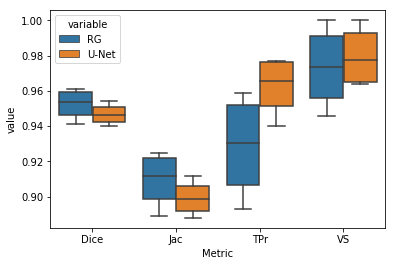

In [36]:
data_long = pd.melt(df, id_vars='Metric')
ax= seaborn.boxplot(x='Metric', y='value', hue='variable', data=data_long)


In [14]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from nilearn import image
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'C:/3DUnetCNN-master/brats/')
from preprocess_ipo_utils import read_data, HU_conversion
from scipy.ndimage import zoom
sys.path.insert(0,'C:/3DUnetCNN-master/unet3d/')
from metrics import compare_volumes_lighter, Dice, Jac, TruePR, VoluM, dice_coefficient
from 3DRegionGrowing.segmentation_functions import resample
from preprocess import arrange_slices
import scipy.io as spio
import pydicom
import pandas as pd
import seaborn


prediction_path = "C:/results/21teste/3DUnetCNN-master/brats/prediction/"
prediction_folder = os.listdir(prediction_path)
in_folder= "G:/CTimages/original/"#+result+"/"
mask_folder = "G:/Masks/pares/"
separate_mask_folder = "G:/Masks/separated/"
separation_path = "G:/Results/Separator/"
rg_results_path = "G:/Results/segmentation_results/Iterative/third/"
#header= ("Paciente - region","Dice_rg","dice_unet","jac_rg","jac_unet","truePr_rg","truePr_unet","vs_rg","vs_unet")
#header= ("Dice","Jac","TPr","VS","Method")
header= ("RG","U-Net","Metric")

result = "40433190"
#predict_file
prediction_file = prediction_path+result+'/'+"{0}_prediction.nii.gz"
prediction_image = nib.load(prediction_file)
prediction = prediction_image.get_data()

truth_file = prediction_path+result+'/'+"{0}_truth.nii.gz"
truth_image = nib.load(truth_file)
truth_folder = truth_image.get_data()

#original-file/original_mask (we only want the original shae)
truth = np.load(mask_folder+'mask_'+result+'.npy')
separador = spio.loadmat(separation_path+'/'+result+'_separator', squeeze_me=True)["separator"]

slices= arrange_slices(in_folder,result)
resize_factor = np.array(truth.shape) / np.array(prediction.shape)
new_real_shape = prediction.shape * resize_factor
new_shape = np.round(new_real_shape)
real_resize_factor = new_shape / prediction.shape

result_orig_size = zoom(prediction, real_resize_factor, order=1)

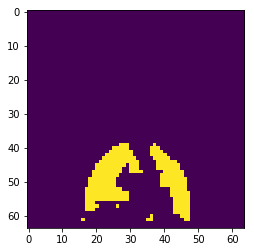

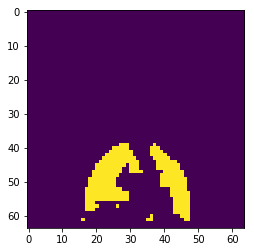

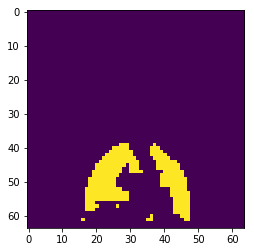

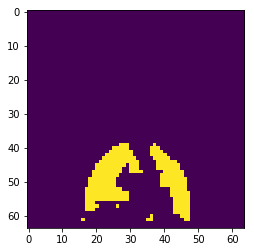

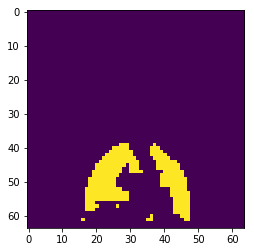

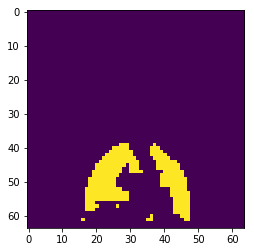

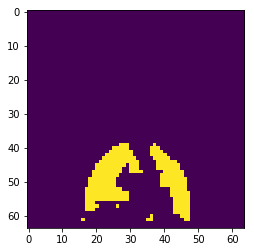

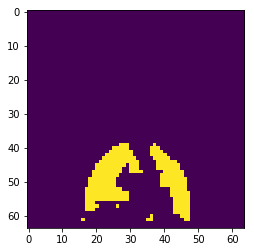

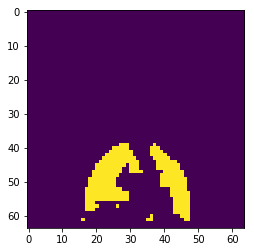

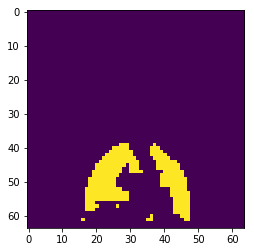

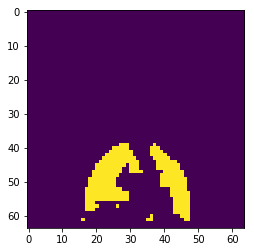

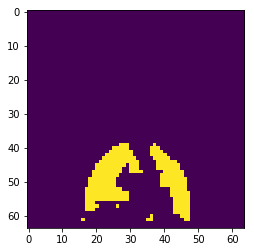

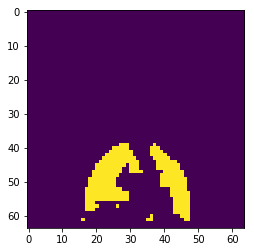

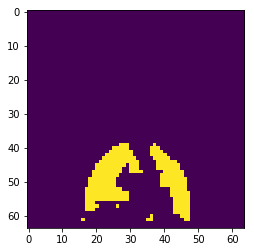

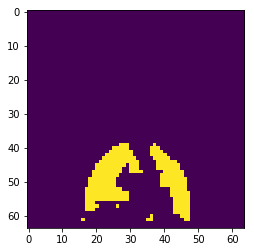

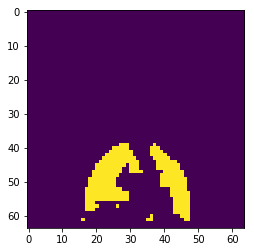

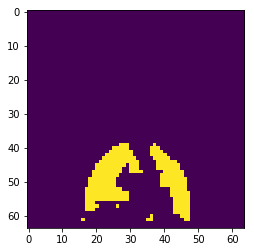

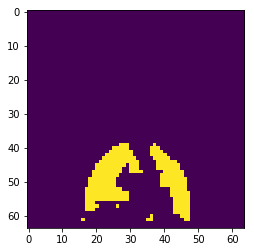

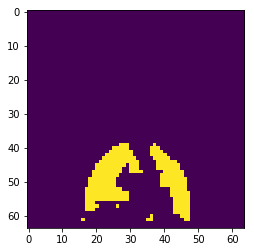

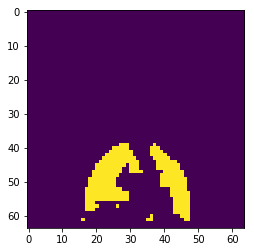

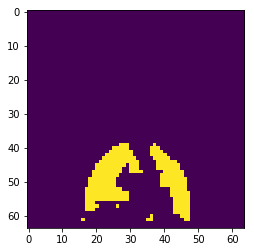

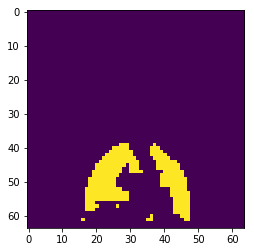

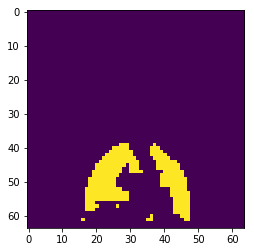

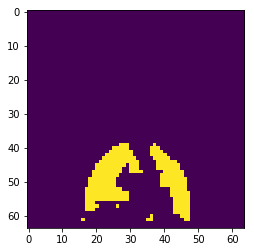

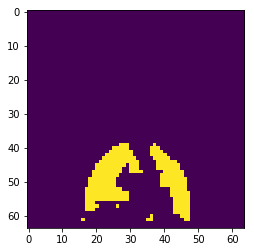

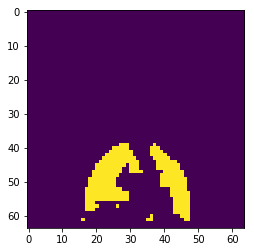

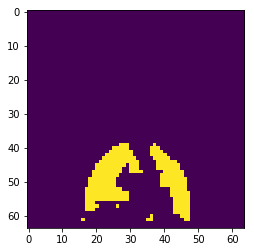

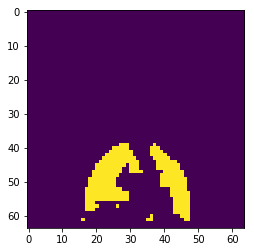

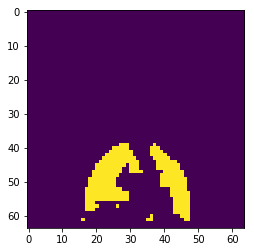

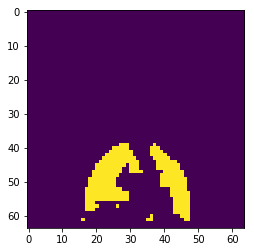

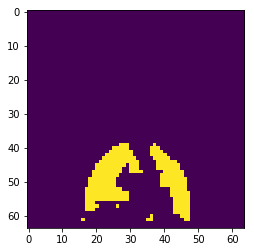

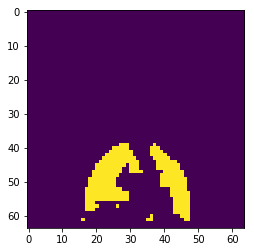

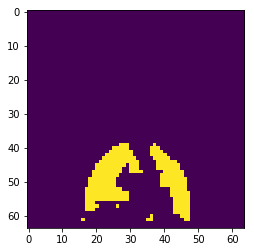

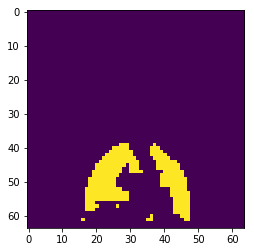

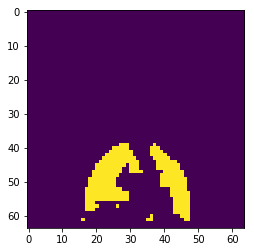

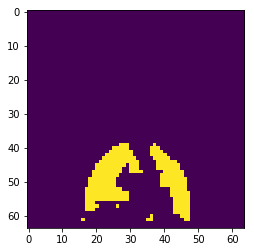

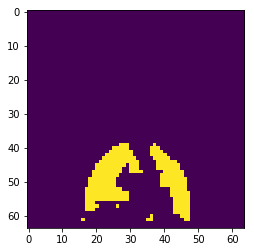

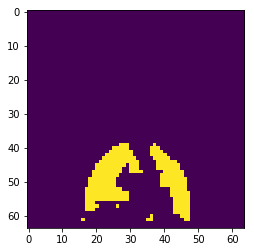

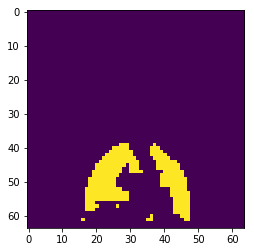

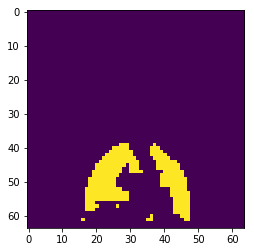

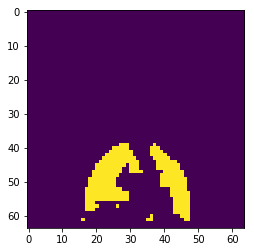

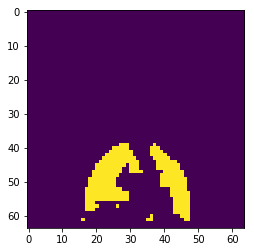

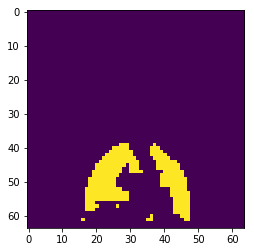

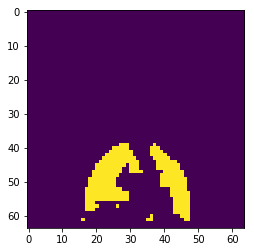

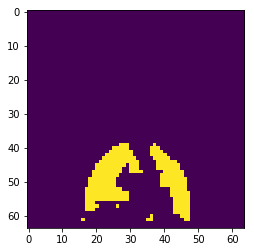

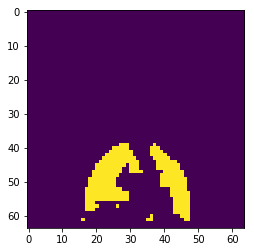

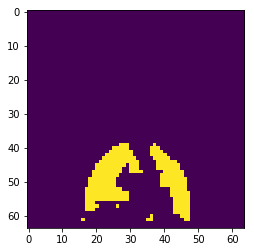

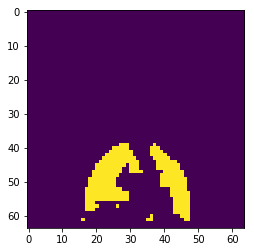

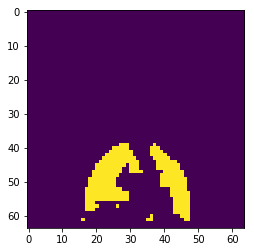

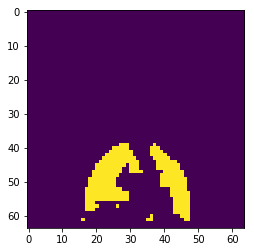

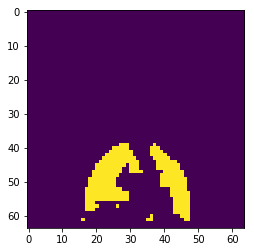

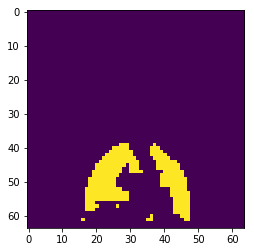

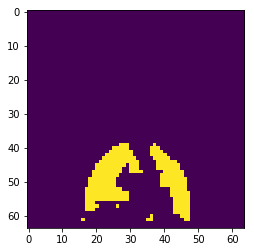

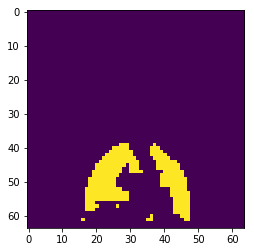

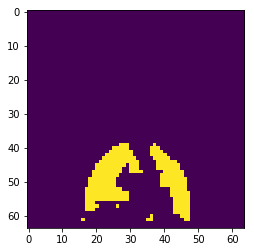

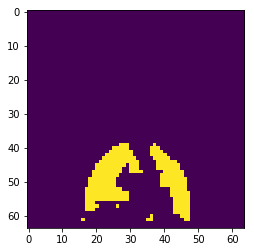

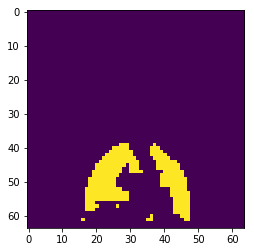

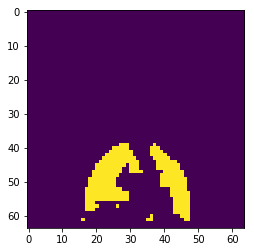

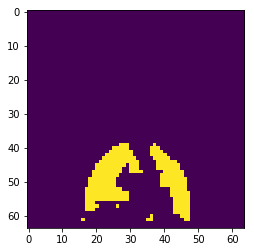

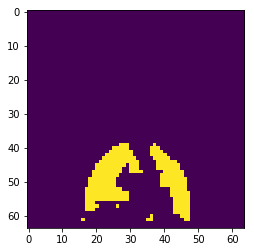

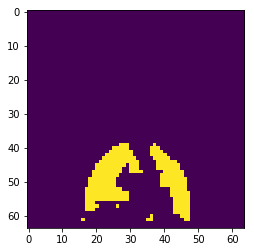

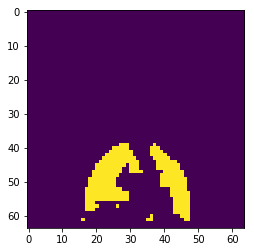

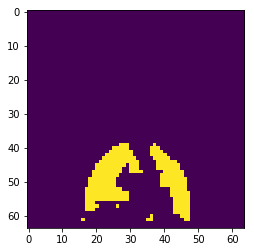

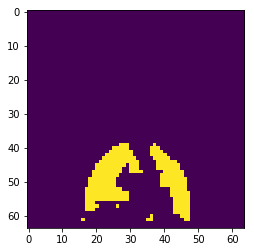

In [15]:
for i in range(prediction.shape[1]):
    plt.imshow(prediction[:,30,:])
    plt.show()